## XGBoost modifications

>- import packages

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
import joblib 
from pathlib import Path

# for data leveling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

>- Define function & modify

In [7]:
# Define functions to calculate NDVI and NDWI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-10)

def calculate_ndwi(nir, swir):
    return (nir - swir) / (nir + swir + 1e-10)

'''
    Enhanced Feature Engineering:
        -  Current features (mean NDVI/NDWI) might be insufficient. Add:

'''
def extract_features(image_path):
    with rasterio.open(image_path) as src:
        bands = src.read()
        nir, red, swir = bands[3], bands[2], bands[4]
        
        # Existing features
        ndvi = calculate_ndvi(nir, red)
        ndwi = calculate_ndwi(nir, swir)
        
        # New features
        return [
            np.mean(ndvi), np.std(ndvi),  # Add standard deviation
            np.mean(ndwi), np.std(ndwi),
            np.percentile(nir, 75),  # Texture features
            np.mean(swir > np.quantile(swir, 0.75))  # Threshold features
        ]


>- load dataset with SMOTE

In [8]:
# Load dataset efficiently
train_dataset_path = Path('../../../data/model/Patches/Train/')
test_dataset_path = Path('../../../data/model/Patches/Test/')
growth_stages = ["germination", "tillering", "grand_growth", "ripening"]
X, X_test, y, y_test = [], [], [], []

for idx, stage in enumerate(growth_stages):
    stage_path = train_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X.append(extract_features(img_path))
        y.append(idx)

X = np.array(X)
y = np.array(y)

# ADD SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

for idx, stage in enumerate(growth_stages):
    stage_path = test_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X_test.append(extract_features(img_path))
        y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

>- setup model

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\user\anaconda3\envs\research_env\lib\site-packages\xgboost\core.py:158: UserWarning: [19:09:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
[0]	validation_0-mlogloss:1.06621	validation_1-mlogloss:1.08477
[1]	validation_0-mlogloss:0.84605	validation_1-mlogloss:0.87476
[2]	validation_0-mlogloss:0.68779	validation_1-mlogloss:0.72340
[3]	validation_0-mlogloss:0.57368	validation_1-mlogloss:0.61652
[4]	validation_0-mlogloss:0.48027	validation_1-mlogloss:0.52741
[5]	validation_0-mlogloss:0.40877	validation_1-mlogloss:0.46040
[6]	validation_0-mlogloss:0.35363	validation_1-mlogloss:0.40766
[7]	validation_0-mlogloss:0.30579	validation_1-mlogloss:0.36241
[8]	validation_0-mlogloss:0.27461	validation_1-mlogloss:0.33276
[9]	validation_0-mlogloss:0.24376	validation_1-mlogloss:0.30439
[10]	validation_0-mlogloss:0.21939	validation_1-mlogloss:0.28142
[11]	validation_0-mlogloss:0.19821	validation_1-mlogloss:0.26162


c:\Users\user\anaconda3\envs\research_env\lib\site-packages\xgboost\core.py:158: UserWarning: [19:09:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-mlogloss:0.17957	validation_1-mlogloss:0.24414
[13]	validation_0-mlogloss:0.16457	validation_1-mlogloss:0.22992
[14]	validation_0-mlogloss:0.15344	validation_1-mlogloss:0.21925
[15]	validation_0-mlogloss:0.14381	validation_1-mlogloss:0.21013
[16]	validation_0-mlogloss:0.13393	validation_1-mlogloss:0.20151
[17]	validation_0-mlogloss:0.12542	validation_1-mlogloss:0.19346
[18]	validation_0-mlogloss:0.11877	validation_1-mlogloss:0.18744
[19]	validation_0-mlogloss:0.11331	validation_1-mlogloss:0.18199
[20]	validation_0-mlogloss:0.10830	validation_1-mlogloss:0.17758
[21]	validation_0-mlogloss:0.10457	validation_1-mlogloss:0.17373
[22]	validation_0-mlogloss:0.10069	validation_1-mlogloss:0.17013
[23]	validation_0-mlogloss:0.09800	validation_1-mlogloss:0.16776
[24]	validation_0-mlogloss:0.09524	validation_1-mlogloss:0.16538
[25]	validation_0-mlogloss:0.09244	validation_1-mlogloss:0.16283
[26]	validation_0-mlogloss:0.09024	validation_1-mlogloss:0.16101
[27]	validation_0-mloglos

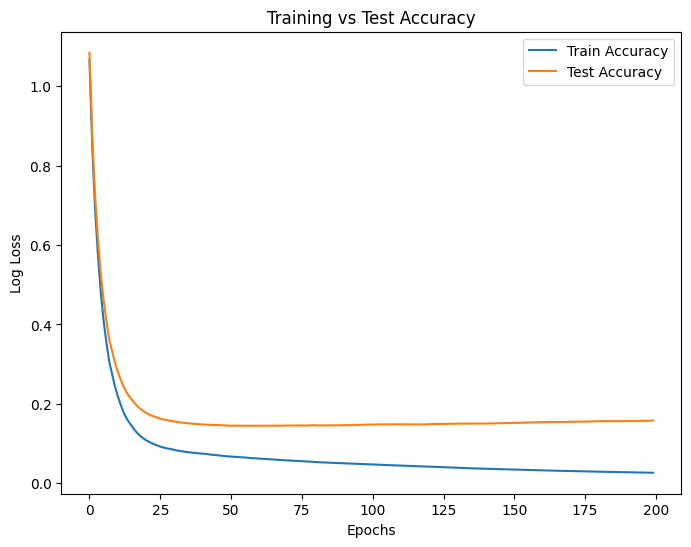

In [9]:
# Define parameter grid for XGBoost
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Initialize XGBoost and GridSearchCV
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    use_label_encoder=False, 
    eval_metric='mlogloss', 
    random_state=42
    )

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, n_jobs=-1, verbose=2, return_train_score=True)

# Train model with cross-validation
# grid_search.fit(X, y)
grid_search.fit(X_res, y_res)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train the model on the entire training dataset
history = best_model.fit(X_res, y_res, eval_set=[(X_res, y_res), (X_test, y_test)], verbose=True)

# Plot training and test accuracy
eval_results = best_model.evals_result()
train_accuracy = eval_results['validation_0']['mlogloss']
test_accuracy = eval_results['validation_1']['mlogloss']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.savefig(Path("../../../logs/IMG/NEW/XGB_V3_accuracy_plot.png"))
plt.show()

>- evaluate model

Test Accuracy: 0.939595660749507
Test Precision: 0.9467227124502434
Test Recall: 0.939595660749507
Test F1 Score: 0.9417647171810924
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2071
           1       0.72      0.88      0.79       499
           2       1.00      0.99      0.99       984
           3       0.99      0.99      0.99       502

    accuracy                           0.94      4056
   macro avg       0.92      0.94      0.93      4056
weighted avg       0.95      0.94      0.94      4056

Saved model to: ..\..\..\models\Map\xgb_model_v3.joblib
Best Cross-Validation Accuracy: 96.95%


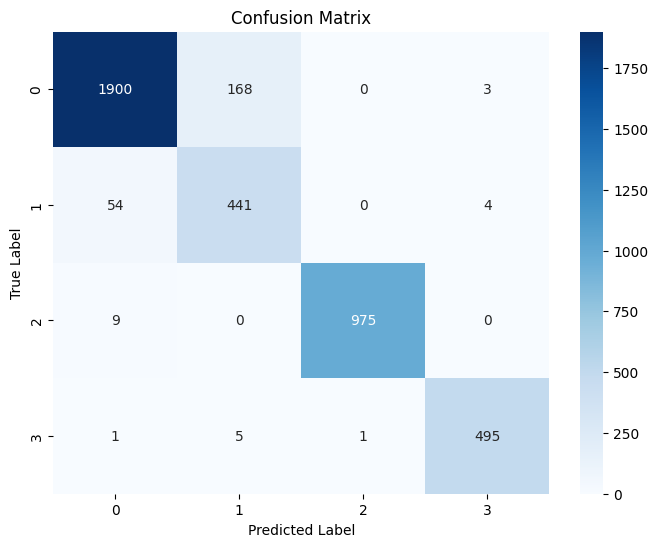

In [10]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# Calculate additional metrics
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
confusion = confusion_matrix(y_test, y_test_pred)

# Log confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(Path("../../../logs/IMG/NEW/XGB_V3_confusion_matrix.png")) # Save confusion matrix

# Print results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Classification Report:\n{test_report}")

# Save the best model to disk
xgb_model_v3 = Path("../../../models/Map/xgb_model_v3.joblib")
joblib.dump(best_model, xgb_model_v3)
print(f"Saved model to: {xgb_model_v3}")

# Evaluate using cross-validation accuracy
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

>- predict

In [11]:
# Load the best model
model = joblib.load(Path("../../../models/Map/xgb_model_v3.joblib"))

def predict_growth_stage(image_path, model):
    features = extract_features(image_path)
    predicted_label = model.predict([features])[0]
    return growth_stages[predicted_label]

new_image = Path('../../../data/model/Test/grand_growth/grand_growth_118FPLAN_76.tif')
predicted_stage = predict_growth_stage(new_image, model)
print(f"Predicted Growth Stage: {predicted_stage}")
print()

Predicted Growth Stage: grand_growth



c:\Users\user\anaconda3\envs\research_env\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
